# Accessibility Data: ML & Predictive Models

This notebook implements three modeling tasks using the **Project Sidewalk Seattle** dataset:

1. **Barrier type classification** — Classify types of accessibility barriers (surface problem, obstacle, curb ramp issue, etc.).
2. **High-risk accessibility hotspots** — Identify hotspots using spatial clustering and risk scoring.
3. **Future problem prediction** — Predict where new accessibility problems are likely to occur.

## Setup and data load

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import cdist

pd.set_option('display.max_columns', 20)
sns.set_style('whitegrid')
%matplotlib inline

In [30]:
df = pd.read_csv('everydayLife_cleaned_dataset.csv')

# Simplify column names
df = df.rename(columns={
    'geometry/coordinates/0': 'lon',
    'geometry/coordinates/1': 'lat',
    'properties/label_type': 'label_type',
    'properties/neighborhood': 'neighborhood',
    'properties/severity': 'severity',
    'properties/is_temporary': 'is_temporary'
})

print('Shape:', df.shape)
print('\nLabel type distribution:')
print(df['label_type'].value_counts())
df.head(10)

Shape: (81973, 9)

Label type distribution:
label_type
CurbRamp          27175
NoSidewalk        19133
NoCurbRamp        16947
SurfaceProblem    12681
Obstacle           5693
Occlusion           253
Other                91
Name: count, dtype: int64


,type,geometry/type,lon,lat,properties/attribute_id,label_type,neighborhood,severity,is_temporary
0,Feature,Point,-122.298981,47.594616,52096165,SurfaceProblem,Atlantic,4.0,False
1,Feature,Point,-122.301071,47.593357,52096166,SurfaceProblem,Atlantic,3.0,False
2,Feature,Point,-122.301079,47.596844,52096167,SurfaceProblem,Atlantic,4.0,False
3,Feature,Point,-122.301071,47.596500,52096168,SurfaceProblem,Atlantic,4.0,False
4,Feature,Point,-122.306274,47.599930,52096365,NoCurbRamp,Atlantic,4.0,False
5,Feature,Point,-122.310371,47.600765,52096374,NoCurbRamp,Atlantic,3.0,False
6,Feature,Point,-122.300201,47.595486,52096414,NoCurbRamp,Atlantic,1.0,False
7,Feature,Point,-122.300064,47.600323,52096415,NoCurbRamp,Atlantic,3.0,False
8,Feature,Point,-122.300980,47.600834,52096416,NoCurbRamp,Atlantic,3.0,False
9,Feature,Point,-122.298859,47.601597,52096417,NoCurbRamp,Atlantic,3.0,False


---
## Task 1: Classify types of accessibility barriers

We train a classifier to predict **barrier type** from location (lon, lat), neighborhood, severity, and temporary flag. This can support automated tagging or imputation when label type is missing.

In [31]:
# Features and target
feature_cols = ['lon', 'lat', 'neighborhood', 'severity', 'is_temporary']
target_col = 'label_type'

X = df[['lon', 'lat', 'severity', 'is_temporary']].copy()
X['is_temporary'] = X['is_temporary'].astype(int)

# Encode neighborhood
le_neighborhood = LabelEncoder()
X['neighborhood_enc'] = le_neighborhood.fit_transform(df['neighborhood'].astype(str))

y = df[target_col]

# Drop rows with missing severity for modeling
mask = X['severity'].notna()
X_clean = X[mask].copy()
y_clean = y[mask]
X_clean = X_clean.fillna(X_clean.median())

X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.25, random_state=42, stratify=y_clean
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

print('Train size:', len(X_train), '| Test size:', len(X_test))

Train size: 61479 | Test size: 20494


In [32]:
clf = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42, n_jobs=-1)
clf.fit(X_train_s, y_train)

y_pred = clf.predict(X_test_s)
print(classification_report(y_test, y_pred, zero_division=0))
print('\nConfusion matrix (rows=true, cols=pred):')
print(confusion_matrix(y_test, y_pred))

                precision    recall  f1-score   support

      CurbRamp       0.85      0.88      0.86      6794
    NoCurbRamp       0.71      0.81      0.76      4237
    NoSidewalk       0.87      0.91      0.89      4784
      Obstacle       0.56      0.34      0.43      1423
     Occlusion       0.61      0.40      0.48        63
         Other       0.60      0.13      0.21        23
SurfaceProblem       0.64      0.53      0.58      3170

      accuracy                           0.78     20494
     macro avg       0.69      0.57      0.60     20494
  weighted avg       0.77      0.78      0.77     20494


Confusion matrix (rows=true, cols=pred):
[[6000  383   71   78    2    0  260]
 [ 248 3446  200   56    1    1  285]
 [  60  203 4347   67    2    1  104]
 [ 238  249  134  487    7    0  308]
 [   8   11    4    5   25    0   10]
 [   4    8    6    2    0    3    0]
 [ 522  579  211  169    4    0 1685]]


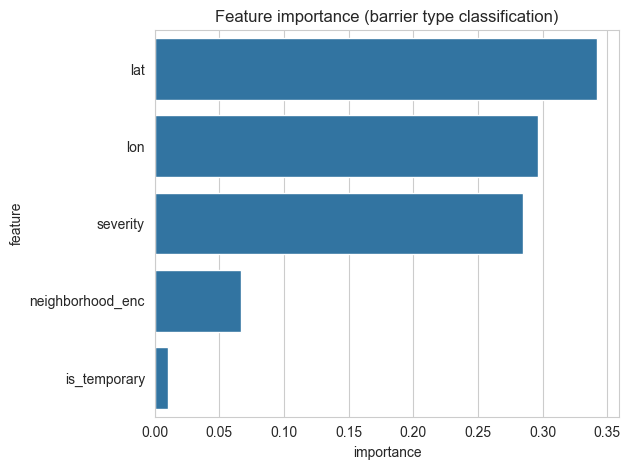

In [33]:
# Feature importance for barrier type classification
imp = pd.DataFrame({
    'feature': X_clean.columns,
    'importance': clf.feature_importances_
}).sort_values('importance', ascending=False)
sns.barplot(data=imp, x='importance', y='feature')
plt.title('Feature importance (barrier type classification)')
plt.tight_layout()
plt.show()

---
## Task 2: High-risk accessibility hotspots

We identify **high-risk hotspots** by:
1. **Spatial clustering** (DBSCAN) to find dense clusters of barriers.
2. **Risk score** per cluster = density × average severity (and optionally weighting by barrier type).

In [34]:
# Use coordinates in a scale suitable for DBSCAN (approx meters for Seattle)
# 1 deg lat ~ 111 km; 1 deg lon ~ 85 km at Seattle's latitude
coords = df[['lon', 'lat']].values
scale_lon = 85e3   # meters per degree lon
scale_lat = 111e3  # meters per degree lat
coords_m = np.column_stack([coords[:, 0] * scale_lon, coords[:, 1] * scale_lat])

# DBSCAN: eps in meters, min_samples = minimum points to form cluster
eps_m = 150   # ~150 m radius
min_samples = 20
db = DBSCAN(eps=eps_m, min_samples=min_samples, n_jobs=-1).fit(coords_m)

df['cluster'] = db.labels_
n_clusters = len(set(db.labels_) - {-1})
n_noise = (db.labels_ == -1).sum()
print(f'Number of clusters: {n_clusters} | Noise points: {n_noise}')

Number of clusters: 142 | Noise points: 2204


In [35]:
# Risk score per cluster: count * mean severity (fill missing severity with median)
sev = df['severity'].fillna(df['severity'].median())
df['severity_filled'] = sev

cluster_stats = df[df['cluster'] != -1].groupby('cluster').agg(
    count=('cluster', 'count'),
    mean_severity=('severity_filled', 'mean'),
    lon=('lon', 'mean'),
    lat=('lat', 'mean')
).reset_index()

cluster_stats['risk_score'] = cluster_stats['count'] * cluster_stats['mean_severity']
cluster_stats = cluster_stats.sort_values('risk_score', ascending=False)

print('Top 15 high-risk clusters (by count × mean severity):')
print(cluster_stats.head(15).to_string())

# High-risk hotspots = top clusters
top_n = 30
hotspots = cluster_stats.head(top_n)

Top 15 high-risk clusters (by count × mean severity):
     cluster  count  mean_severity         lon        lat  risk_score
0          0  33697       2.606998 -122.319124  47.606284     87848.0
1          1  28372       2.911110 -122.334484  47.675034     82594.0
15        15   4441       2.531412 -122.398798  47.645909     11242.0
67        67   1417       2.585039 -122.386073  47.542662      3663.0
10        10   1101       3.136240 -122.302075  47.726097      3453.0
11        11    748       4.108289 -122.297715  47.709270      3073.0
86        86    595       3.452101 -122.388900  47.527433      2054.0
68        68    420       3.947619 -122.361100  47.521825      1658.0
74        74    426       3.791080 -122.326722  47.532764      1615.0
6          6    345       3.649275 -122.318270  47.714476      1259.0
22        22    371       2.924528 -122.256071  47.510940      1085.0
84        84    382       2.526178 -122.392450  47.555489       965.0
115      115    227       4.193833 -

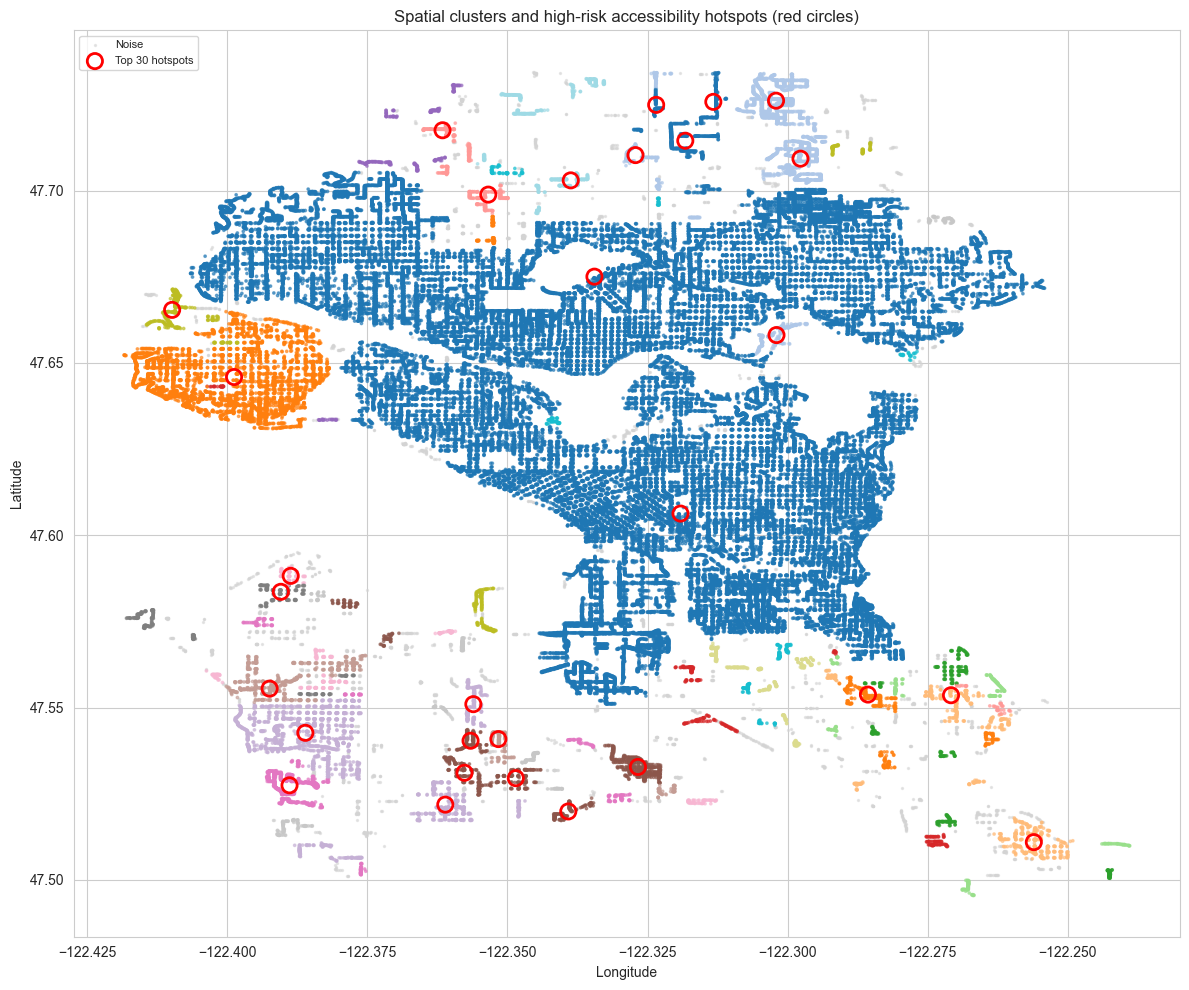

In [36]:
# Visualize clusters and high-risk hotspots
fig, ax = plt.subplots(figsize=(12, 10))

# All points, colored by cluster (noise in gray)
in_cluster = df['cluster'] != -1
ax.scatter(df.loc[~in_cluster, 'lon'], df.loc[~in_cluster, 'lat'], c='lightgray', s=2, alpha=0.5, label='Noise')
sc = ax.scatter(df.loc[in_cluster, 'lon'], df.loc[in_cluster, 'lat'], c=df.loc[in_cluster, 'cluster'], s=3, cmap='tab20', alpha=0.6)

# Mark top hotspots
ax.scatter(hotspots['lon'], hotspots['lat'], s=120, facecolors='none', edgecolors='red', linewidths=2, label=f'Top {top_n} hotspots')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Spatial clusters and high-risk accessibility hotspots (red circles)')
ax.legend(loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()

---
## Task 3: Predict where future accessibility problems are likely to occur

We **grid** the city into small cells and model **barrier count (or binary risk)** per cell using:
- Neighborhood (encoded)
- Existing barrier density in the cell / nearby
- Central coordinates of the cell

Then we train a model to predict barrier count (or high/medium/low risk) for any grid cell, so we can score **unobserved or partially observed** areas as likely future problem locations.

In [37]:
# Create grid over Seattle (approximate bounding box from data)
lon_min, lon_max = df['lon'].min(), df['lon'].max()
lat_min, lat_max = df['lat'].min(), df['lat'].max()

grid_res = 0.002   # ~200 m cells
lon_edges = np.arange(lon_min, lon_max + grid_res, grid_res)
lat_edges = np.arange(lat_min, lat_max + grid_res, grid_res)

# Assign each point to a grid cell
df['grid_lon'] = np.digitize(df['lon'], lon_edges) - 1
df['grid_lat'] = np.digitize(df['lat'], lat_edges) - 1
df['grid_id'] = df['grid_lon'].astype(str) + '_' + df['grid_lat'].astype(str)

# Target: barrier count per cell (and binary high-risk: count >= threshold)
cell_counts = df.groupby('grid_id').size().reindex(df['grid_id'].unique()).fillna(0).astype(int)
cell_agg = df.groupby('grid_id').agg(
    count=('grid_id', 'size'),
    mean_severity=('severity_filled', 'mean'),
    lon_center=('lon', 'mean'),
    lat_center=('lat', 'mean'),
    n_neighborhoods=('neighborhood', 'nunique')
).reset_index()

# All grid cells (including empty) for prediction
grid_lon_centers = (lon_edges[:-1] + lon_edges[1:]) / 2
grid_lat_centers = (lat_edges[:-1] + lat_edges[1:]) / 2
all_cells = []
for i, lon_c in enumerate(grid_lon_centers):
    for j, lat_c in enumerate(grid_lat_centers):
        all_cells.append({'grid_id': f'{i}_{j}', 'lon_center': lon_c, 'lat_center': lat_c})
grid_df = pd.DataFrame(all_cells)

grid_df = grid_df.merge(cell_agg[['grid_id', 'count', 'mean_severity', 'n_neighborhoods']], on='grid_id', how='left')
grid_df['count'] = grid_df['count'].fillna(0).astype(int)
grid_df['mean_severity'] = grid_df['mean_severity'].fillna(0)
grid_df['n_neighborhoods'] = grid_df['n_neighborhoods'].fillna(0)

# High-risk label: top quartile of counts (or use a fixed threshold)
threshold = grid_df['count'].quantile(0.75)
grid_df['high_risk'] = (grid_df['count'] >= threshold).astype(int)
print('Grid shape:', len(grid_lon_centers), 'x', len(grid_lat_centers), '| Cells with barriers:', (grid_df['count'] > 0).sum())
print('High-risk threshold (count >=):', threshold)
grid_df.head(10)

Grid shape: 90 x 120 | Cells with barriers: 4212
High-risk threshold (count >=): 12.0


,grid_id,lon_center,lat_center,count,mean_severity,n_neighborhoods,high_risk
0,0_0,-122.417427,47.496449,0,0.0,0.0,0
1,0_1,-122.417427,47.498449,0,0.0,0.0,0
2,0_2,-122.417427,47.500449,0,0.0,0.0,0
3,0_3,-122.417427,47.502449,0,0.0,0.0,0
4,0_4,-122.417427,47.504449,0,0.0,0.0,0
5,0_5,-122.417427,47.506449,0,0.0,0.0,0
6,0_6,-122.417427,47.508449,0,0.0,0.0,0
7,0_7,-122.417427,47.510449,0,0.0,0.0,0
8,0_8,-122.417427,47.512449,0,0.0,0.0,0
9,0_9,-122.417427,47.514449,0,0.0,0.0,0


In [38]:
# Features for prediction: location + spatial lag (mean count in neighboring cells)
# Simple version: use lon_center, lat_center and optionally KDE/density from raw points
from sklearn.neighbors import NearestNeighbors

# Only cells that have at least one observation (we'll train on these, then predict on all)
train_cells = grid_df[grid_df['count'] > 0].copy()
train_cells['log_count'] = np.log1p(train_cells['count'])

X_grid = train_cells[['lon_center', 'lat_center', 'mean_severity', 'n_neighborhoods']].copy()
X_grid['mean_severity'] = X_grid['mean_severity'].fillna(0)

# Spatial lag: average count in nearby cells (using 8 neighbors in grid)
def spatial_lag(gdf, col='count', k=8):
    coords = gdf[['lon_center', 'lat_center']].values
    nn = NearestNeighbors(n_neighbors=k+1).fit(coords)
    dist, idx = nn.kneighbors(coords)
    lag = []
    for i in range(len(gdf)):
        neighbor_counts = gdf['count'].iloc[idx[i][1:]].values  # exclude self
        lag.append(neighbor_counts.mean())
    return np.array(lag)

train_cells['count_lag'] = spatial_lag(train_cells)
X_grid['count_lag'] = train_cells['count_lag']

y_count = train_cells['count'].values
y_high_risk = train_cells['high_risk'].values

X_tr, X_te, y_tr, y_te = train_test_split(X_grid, y_count, test_size=0.25, random_state=42)
X_tr_r, X_te_r, y_tr_r, y_te_r = train_test_split(X_grid, y_high_risk, test_size=0.25, random_state=42, stratify=y_high_risk)

scaler_g = StandardScaler()
X_tr_s = scaler_g.fit_transform(X_tr)
X_te_s = scaler_g.transform(X_te)
X_tr_rs = scaler_g.fit_transform(X_tr_r)
X_te_rs = scaler_g.transform(X_te_r)

In [39]:
# Model A: Predict barrier count (regression)
reg = RandomForestRegressor(n_estimators=150, max_depth=15, random_state=42, n_jobs=-1)
reg.fit(X_tr_s, y_tr)
y_pred_count = reg.predict(X_te_s)
y_pred_count = np.maximum(0, y_pred_count)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
print('Count prediction (test):')
print('  MAE:', round(mean_absolute_error(y_te, y_pred_count), 2))
print('  RMSE:', round(np.sqrt(mean_squared_error(y_te, y_pred_count)), 2))
print('  R2:', round(r2_score(y_te, y_pred_count), 4))

Count prediction (test):
  MAE: 8.77
  RMSE: 11.45
  R2: 0.3238


In [40]:
# Model B: Predict high-risk (binary classification)
clf_risk = RandomForestClassifier(n_estimators=150, max_depth=15, random_state=42, n_jobs=-1)
clf_risk.fit(X_tr_rs, y_tr_r)
y_pred_risk = clf_risk.predict(X_te_rs)
print(classification_report(y_te_r, y_pred_risk, target_names=['Low risk', 'High risk']))

              precision    recall  f1-score   support

    Low risk       0.68      0.58      0.63       376
   High risk       0.78      0.85      0.82       677

    accuracy                           0.75      1053
   macro avg       0.73      0.71      0.72      1053
weighted avg       0.75      0.75      0.75      1053



In [41]:
# Predict on ALL grid cells (including empty) to find where future problems are likely
# We need features for all cells: lon, lat, and spatial lag (compute from current counts)
grid_df['count_lag'] = spatial_lag(grid_df)
grid_df['mean_severity'] = grid_df['mean_severity'].fillna(0)
X_all = grid_df[['lon_center', 'lat_center', 'mean_severity', 'n_neighborhoods', 'count_lag']].fillna(0)
X_all_s = scaler_g.transform(X_all)

grid_df['predicted_count'] = np.maximum(0, reg.predict(X_all_s))
grid_df['predicted_high_risk'] = clf_risk.predict(X_all_s)

# Likely future problem areas: high predicted count but currently low or zero observed count
grid_df['observed_count'] = grid_df['count']
grid_df['future_risk_score'] = grid_df['predicted_count'] - grid_df['observed_count']
grid_df['future_risk_score'] = grid_df['future_risk_score'].clip(lower=0)

future_hotspots = grid_df.nlargest(50, 'future_risk_score')
print('Top 20 cells where future accessibility problems are likely (high predicted, low current):')
print(future_hotspots[['lon_center', 'lat_center', 'observed_count', 'predicted_count', 'future_risk_score']].head(20).to_string())

Top 20 cells where future accessibility problems are likely (high predicted, low current):
      lon_center  lat_center  observed_count  predicted_count  future_risk_score
7723 -122.289427   47.582449               6        41.508823          35.508823
5444 -122.327427   47.584449               1        34.779221          33.779221
6879 -122.303427   47.574449              43        76.153333          33.153333
7721 -122.289427   47.578449              16        47.986873          31.986873
6523 -122.309427   47.582449              11        42.919998          31.919998
6765 -122.305427   47.586449              28        59.906667          31.906667
5205 -122.331427   47.586449               4        35.594901          31.594901
5720 -122.323427   47.656449              10        40.090449          30.090449
7536 -122.293427   47.688449               4        33.745279          29.745279
5848 -122.321427   47.672449               7        35.151394          28.151394
7249 -122.297427  

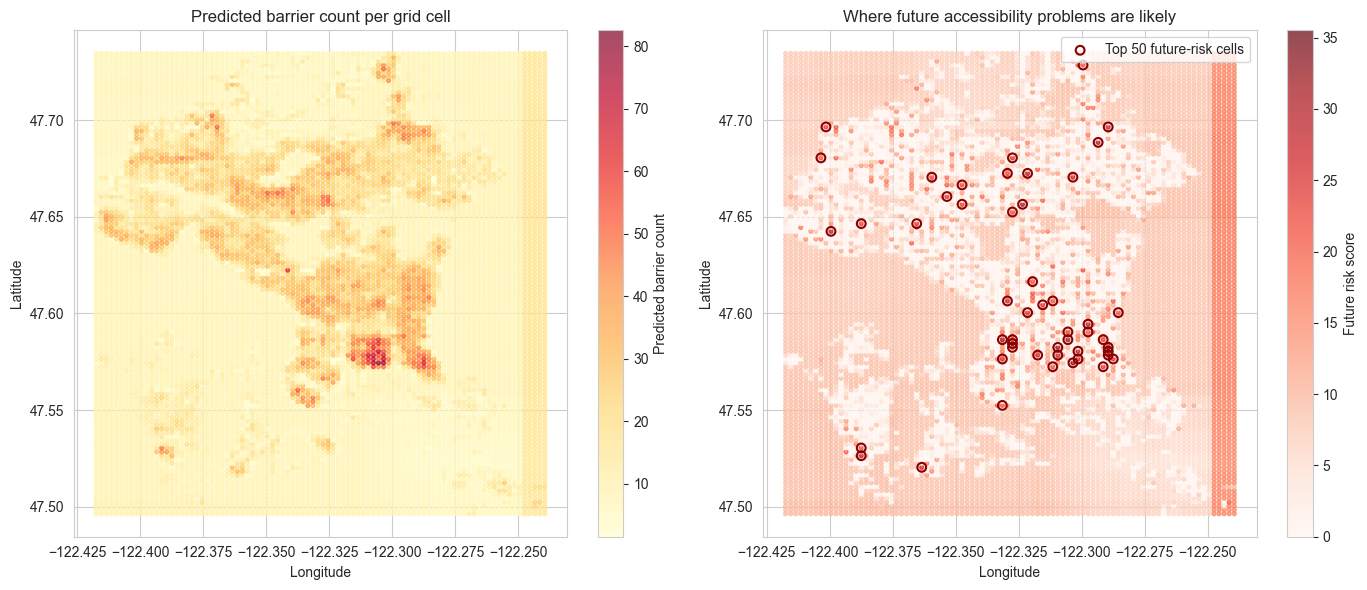

In [42]:
# Map: predicted high-risk and future problem hotspots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

ax = axes[0]
sc = ax.scatter(grid_df['lon_center'], grid_df['lat_center'], c=grid_df['predicted_count'], s=8, cmap='YlOrRd', alpha=0.7)
plt.colorbar(sc, ax=ax, label='Predicted barrier count')
ax.set_title('Predicted barrier count per grid cell')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

ax = axes[1]
sc = ax.scatter(grid_df['lon_center'], grid_df['lat_center'], c=grid_df['future_risk_score'], s=8, cmap='Reds', alpha=0.7)
plt.colorbar(sc, ax=ax, label='Future risk score')
ax.scatter(future_hotspots['lon_center'], future_hotspots['lat_center'], s=40, facecolors='none', edgecolors='darkred', linewidths=1.5, label='Top 50 future-risk cells')
ax.set_title('Where future accessibility problems are likely')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend()
plt.tight_layout()
plt.show()

---
## Summary

- **Task 1** — Barrier type is predicted from location, neighborhood, severity, and temporary flag; feature importance highlights which factors drive barrier type.
- **Task 2** — DBSCAN finds spatial clusters; risk score (count × mean severity) ranks clusters to identify **high-risk accessibility hotspots**.
- **Task 3** — Grid-based count and high-risk models, plus a future-risk score (predicted − observed), identify **where future accessibility problems are likely** for prioritization and planning.